# Tweet Turing Test: Detecting Disinformation on Twitter  

|          | Group #2 - Disinformation Detectors                     |
|---------:|---------------------------------------------------------|
| Members  | John Johnson, Katy Matulay, Justin Minnion, Jared Rubin |
| Notebook | `05_BERT_fine_tuner.ipynb`                              |
| Purpose  | A notebook to fine-tune BERT models.                    |

This notebook was created to make the model fine-tuning process more traceable and reproducable. What will appear in GitHub is a snapshot of the one model's fine tuning run; not pictured are the many (many) times this notebook was executed (at least once per fine-tuned model instance).

*Assumptions*  
 - The dataset being used has binary class labels following convention: 0 = authentic tweet; 1 = troll tweet
 - The execution environment has internet access (to download models from huggingface.co)
 - The execution environment has a CUDA-capable GPU available

*Notes*
 - Notebook kernel must be completely restarted between runs to release reserved VRAM from the GPU.
 - Notebook contains our usual code to load dataset file from GCP bucket, but model files are always saved locally regardless of `local_or_cloud` setting.
 - Approach to model fine-tuning is based on tutorial from: https://huggingface.co/docs/transformers/training
 - Optimization/convergence tips from: https://huggingface.co/docs/transformers/perf_train_gpu_one
 - Additional help from: https://www.youtube.com/watch?v=V1-Hm2rNkik&t=351s

# 1 - Setup

In [1]:
# imports from Python standard library
import os
import json
import pathlib
import shutil
import zipfile

# imports requiring installation
#   connection to Google Cloud Storage
from google.cloud import storage            # pip install google-cloud-storage
from google.oauth2 import service_account   # pip install google-auth

#  data science packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pynvml import *    # for debugging

# 🤗 (huggingface) packages
import evaluate
from datasets import Dataset, ClassLabel
from transformers import BertTokenizerFast, BertweetTokenizer, DistilBertTokenizerFast, RobertaTokenizerFast, XLMRobertaTokenizerFast
from transformers import BertForSequenceClassification, DistilBertForSequenceClassification, RobertaForSequenceClassification
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments, Trainer

In [2]:
# imports from tweet_turing.py
import tweet_turing as tur      # note - different import approach from prior notebooks

# imports from tweet_turing_paths.py
from tweet_turing_paths import local_data_paths, local_snapshot_paths, gcp_data_paths, \
    gcp_snapshot_paths, gcp_project_name, gcp_bucket_name, gcp_key_file

In [3]:
# pandas options
pd.set_option('display.max_colwidth', None)

sns.set_theme(context='paper', style='ticks', palette='bright', font='georgia', rc={'figure.dpi': 200})
twitter_colors = {
    'blue': r"#1DA1F2",     # source: https://usbrandcolors.com/twitter-colors/
    'black': r"#14171A",
    'dark gray': r"#657786",
    'dark blue': r"#0f5580" # "blue" with brightness changed 88% to 50%, non-standard color
    }

In [4]:
# requires Ampere-architecture GPU to run this datatype
import torch
torch.backends.cuda.matmul.allow_tf32 = True

## Local or Cloud?

Decide here whether to run notebook with local data or GCP bucket data
 - if the working directory of this notebook has a "../data/" folder with data loaded (e.g. working on local computer or have data files loaded to a cloud VM) then use the "local files" option and comment out the "gcp bucket files" option
 - if this notebook is being run from a GCP VM (preferrably in the `us-central1` location) then use the "gcp bucket files" option and comment out the "local files" option

In [5]:
# option: local files
local_or_cloud: str = "local"   # comment/uncomment this line or next

# option: gcp bucket files
#local_or_cloud: str = "cloud"   # comment/uncomment this line or previous

# don't comment/uncomment for remainder of cell
if (local_or_cloud == "local"):
    data_paths = local_data_paths
    snapshot_paths = local_snapshot_paths
elif (local_or_cloud == "cloud"):
    data_paths = gcp_data_paths
    snapshot_paths = gcp_snapshot_paths
else:
    raise ValueError("Variable 'local_or_cloud' can only take on one of two values, 'local' or 'cloud'.")
    # subsequent cells will not do this final "else" check

In [6]:
# this cell only needs to run its code if local_or_cloud=="cloud"
#   (though it is harmless if run when local_or_cloud=="local")
gcp_storage_client: storage.Client = None
gcp_bucket: storage.Bucket = None

if (local_or_cloud == "cloud"):
    gcp_storage_client = tur.get_gcp_storage_client(project_name=gcp_project_name, key_file=gcp_key_file)
    gcp_bucket = tur.get_gcp_bucket(storage_client=gcp_storage_client, bucket_name=gcp_bucket_name)

In [7]:
# debug
# from huggingface tutorial: https://huggingface.co/docs/transformers/perf_train_gpu_one#efficient-training-on-a-single-gpu
def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

# 2 - Load Dataset

Starting with the ten-percent sample with NLP-preprocessing completed from notebook **`04_nlp_preprocess_for_BERT.ipynb`**.

In [8]:
# note this cell requires package `pyarrow` to be installed in environment
parq_filename: str = "data_sample_ten_percent_NLP_preprocessed.parquet.gz"
parq_path: str = f"{snapshot_paths['parq_snapshot']}{parq_filename}"

if (local_or_cloud == "local"):
    df = pd.read_parquet(parq_path, engine='pyarrow')
elif (local_or_cloud == "cloud"):
    df = tur.get_gcp_object_from_parq_as_df(bucket=gcp_bucket, object_name=parq_path)

In [9]:
df.head(3)

,external_author_id,author,content,region,language,following,followers,updates,post_type,is_retweet,...,has_url,emoji_text,emoji_count,publish_date,class,following_ratio,class_numeric,RUS_lett_count,content_demoji,content_no_emoji
0,23785050,radiowoody,"To live dangerously on Friday the 13th, we're doing the radio show from the UNLUCKIEST place on earth! The @TennesseeTitans Locker Room!",Nashville Tennessee,en,2585,5710,2,NaN,0.0,...,0,[],0,2013-12-13 10:03:43+00:00,Verified,0.452635,0,0,"To live dangerously on Friday the 13th, we're doing the radio show from the UNLUCKIEST place on earth! The @TennesseeTitans Locker Room!","To live dangerously on Friday the 13th, we're doing the radio show from the UNLUCKIEST place on earth! The @TennesseeTitans Locker Room!"
1,59020162,matthewpouliot,@legsanity I like it. Almost like a free Gio. Pujols is still about as good of a bet as Gonzalez the rest of the way.,Florida,en,999,12637,0,replied_to,0.0,...,0,[],0,2015-04-26 20:13:58+00:00,Verified,0.079047,0,0,@legsanity I like it. Almost like a free Gio. Pujols is still about as good of a bet as Gonzalez the rest of the way.,@legsanity I like it. Almost like a free Gio. Pujols is still about as good of a bet as Gonzalez the rest of the way.
2,1656024374,IMISSOBAMA,Man servants can have a good purpose as long as they come with cash and don't touch me ever.,United States,en,473,760,4122,RETWEET,1.0,...,0,[],0,2016-12-24 13:12:00+00:00,Troll,0.621551,1,0,Man servants can have a good purpose as long as they come with cash and don't touch me ever.,Man servants can have a good purpose as long as they come with cash and don't touch me ever.


In [10]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362314 entries, 0 to 362313
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   external_author_id  362314 non-null  string             
 1   author              362314 non-null  string             
 2   content             362314 non-null  string             
 3   region              344249 non-null  string             
 4   language            362314 non-null  category           
 5   following           362314 non-null  uint64             
 6   followers           362314 non-null  uint64             
 7   updates             362314 non-null  uint64             
 8   post_type           154729 non-null  category           
 9   is_retweet          362314 non-null  float64            
 10  account_category    362314 non-null  category           
 11  tweet_id            362314 non-null  string             
 12  tco1_step1      

In [11]:
df['class'].unique()

['Verified', 'Troll']
Categories (2, object): ['Troll', 'Verified']

In [12]:
df.loc[df['emoji_count'] > 3, ['content', 'content_demoji', 'content_no_emoji', 'emoji_count']].sample(5, random_state=3)

,content,content_demoji,content_no_emoji,emoji_count
232301,RT DebAlwaystrump: Congress looking CORRUPT♨ 2 America😠thinks we are STUPID⤵ MUELLER is a DIRTY COP🚨 Russia was 4 … https://t.co/sVXXXBIjSh,RT DebAlwaystrump: Congress looking CORRUPT:hot springs: 2 America:angry face:thinks we are STUPID:right arrow curving down: MUELLER is a DIRTY COP:police car light: Russia was 4 … https://t.co/sVXXXBIjSh,RT DebAlwaystrump: Congress looking CORRUPT 2 Americathinks we are STUPID MUELLER is a DIRTY COP Russia was 4 … https://t.co/sVXXXBIjSh,4
203651,RT Laura_K69: GOOD LUCK!! 🤣🤣🤣🤣 https://t.co/pc4FYSEscE,RT Laura_K69: GOOD LUCK!! :rolling on the floor laughing::rolling on the floor laughing::rolling on the floor laughing::rolling on the floor laughing: https://t.co/pc4FYSEscE,RT Laura_K69: GOOD LUCK!! https://t.co/pc4FYSEscE,4
32502,"TRIGGER WARNING: Beware before reading my new @Townhallcom column, ""Dating Tips For Prominent Democrats."" It yields maximum kurtness. 💥🔥💥🔥💥🔥💥🤷🏼‍♂️🔥💥🔥💥🔥💥 https://t.co/9EGBRNlw1j","TRIGGER WARNING: Beware before reading my new @Townhallcom column, ""Dating Tips For Prominent Democrats."" It yields maximum kurtness. :collision::fire::collision::fire::collision::fire::collision::man shrugging: medium-light skin tone::fire::collision::fire::collision::fire::collision: https://t.co/9EGBRNlw1j","TRIGGER WARNING: Beware before reading my new @Townhallcom column, ""Dating Tips For Prominent Democrats."" It yields maximum kurtness. https://t.co/9EGBRNlw1j",14
186365,RT @BNPPARIBASOPEN: How does @EVesnina001 lose her #BNPPO17 🏆 midway through her champion's press conference? 🎥😂➡️ https://t.co/RbDT7nlRt7,RT @BNPPARIBASOPEN: How does @EVesnina001 lose her #BNPPO17 :trophy: midway through her champion's press conference?\n\n:movie camera::face with tears of joy::right arrow: https://t.co/RbDT7nlRt7,RT @BNPPARIBASOPEN: How does @EVesnina001 lose her #BNPPO17 midway through her champion's press conference?\n\n https://t.co/RbDT7nlRt7,4
303189,RT @funsized411: 💯💯💯💯💯 RT @TheMisterMarcus: I'm okay with Duke losing even if it ruins my bracket.,RT @funsized411: :hundred points::hundred points::hundred points::hundred points::hundred points: RT @TheMisterMarcus: I'm okay with Duke losing even if it ruins my bracket.,RT @funsized411: RT @TheMisterMarcus: I'm okay with Duke losing even if it ruins my bracket.,5


# 3 - Choose Dataset Fields and Model

## 3.1 - Set Args

To make the subsequent encoding/training code more modular, set as many args as we can within this cell.

In [13]:
# Step 0 - Define model choices and their respective classes.
pretrained_models = {
    'bert-base-uncased': {
        'name': 'bert-base-uncased',                # https://huggingface.co/bert-base-uncased
        'tokenizer': BertTokenizerFast,
        'model': BertForSequenceClassification,
    },
    'distilbert-base-uncased': {                    # https://huggingface.co/distilbert-base-uncased
        'name': 'distilbert-base-uncased',
        'tokenizer': DistilBertTokenizerFast,
        'model': DistilBertForSequenceClassification,
    },
    'roberta-base': {                               # https://huggingface.co/roberta-base
        'name': 'roberta-base',
        'tokenizer': RobertaTokenizerFast,          # note: roberta-base is case sensitive
        'model': RobertaForSequenceClassification,  # note: this class is chosen by AutoModel
    },
    'vinai/bertweet-base': {                        # https://huggingface.co/vinai/bertweet-base
        'name': 'vinai/bertweet-base',
        'tokenizer': BertweetTokenizer,             # note: bertweet-base is case sensitive
        'model': RobertaForSequenceClassification,  # note: this class is chosen by AutoModel
    },
    'Twitter/twhin-bert-base': {                    # https://huggingface.co/Twitter/twhin-bert-base
        'name': 'Twitter/twhin-bert-base',
        'tokenizer': XLMRobertaTokenizerFast,       # twhin-bert's pre-training tokenizer is 'xlm-roberta-base' according to https://arxiv.org/pdf/2209.07562v1.pdf
        'model': BertForSequenceClassification,     # note: confirmed this class is chosen by AutoModel
    },
}

In [14]:
# Step 1 - Select the pre-trained model (must be a key in `pretrained_models` above)
pretrained_model_choice = 'distilbert-base-uncased'
pretrained_model = pretrained_models[pretrained_model_choice]

# Step 2 - Choose a descriptive name for this fine-tuning run.
#   Suggested format: [model name]-[2*max_tweets_per_class in thousands]k__[YYYY-MM-DD]
run_name = "distilbert-base-uncased-200k__2023-03-07"

# Step 3 - Choose a folder name for where to store the output of the model 
#   Will be created as a subfolder of `../data/models/`
output_dir_name = 'distilbert-base-uncased-200k'

# Step 4 - Choose which columns from dataframe will be used.
content_column = 'content_no_emoji'
class_column = 'class_numeric'          # Assumes: 0=authentic, 1=troll
pk_column = 'tweet_id'                  # Used to identify which tweets were used for fine tuning and exclude them from later testing

# Step 5A - Choose tokenizer args
#   Note: these are passed on to tokenizer object as keyword args
common_tokenizer_args = {
    'padding': 'longest', 
    'truncation': True, 
    'return_tensors': 'pt', 
    #'max_length': 256,
}

# Step 5B - Choose model args
#   Note: these are passed on to model object as keyword args
common_model_args = {
    'num_labels': 2,
    #'output_hidden_states': True,
}

# Step 5C - Choose trainer args
#   Note: these are passed on to trainer object as keyword args
#   Docs: https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments
common_train_args = {
    #### model output
    'run_name': run_name,
    'output_dir': f'../data/models/{output_dir_name}',
    'save_strategy': 'epoch',
    'save_total_limit': 1,
    #### training hyperparams
    'num_train_epochs': 10,
    'per_device_train_batch_size': 32,
    'per_device_eval_batch_size': 32,
    'gradient_accumulation_steps': 8,
    #'gradient_checkpointing': True,
    #'tf32': True,                      # requires Ampere, more speed but more VRAM used
    #'bf16': True,                      # requires Ampere
    #'warmup_steps': 500,
    'weight_decay': 0.01,
    #### evaluation during training
    # 'evaluation_strategy': 'steps',
    # 'eval_steps': 100,
    'evaluation_strategy': 'epoch',
    'logging_strategy': 'epoch',
    'log_level': 'warning',
}

# Step 6 - Choose how many tweets to fine-tune with, and test split fraction size
# Notes:
#   - Sets maximum tweets (per class) used for fine tuning but not including evaluation (set to None for no limit)
#       e.g. If this value is 5000, a maximum of 5000 troll and 5000 authentic tweets will be used
#       for a total of 10,000 tweets used for fine tuning. If `test_fraction` is 0.2, then 2,000 additional
#       tweets will be used for testing the fine tuned model, so 12,000 total tweets will be ingested.
#   - `max_tweets_per_class` is assumed to be less than total number of tweets per class in `df` (or else pandas yells)
max_tweets_per_class = 100000
test_fraction = 0.20            # within range (0.0, 1.0)

# Step 7 - (Optional) Set random seed values for reproducability
sampling_random_seed = 42       # for reproducability, and "the answer to life, the universe, and everything"
train_test_random_seed = 3      # for reproducability, and "the number of the counting shall be three"


## 3.2 - Convert Pandas Dataframe to 🤗 Dataset

In [15]:
# for model summary we can track how long it took to encode and train
time_encoding = None
time_training = None

# create a view (not a copy) of dataframe
if (max_tweets_per_class is None):
    df_view = df[[content_column, class_column, pk_column]]
else:
    n_tweets = int(max_tweets_per_class * (1.0 + test_fraction))     # "gross up" the number of tweets ingested (see section 3.1 above)

    df_view = pd.concat(
        [
            df.loc[df[class_column] == 1, [content_column, class_column, pk_column]].sample(n=n_tweets, random_state=sampling_random_seed),
            df.loc[df[class_column] == 0, [content_column, class_column, pk_column]].sample(n=n_tweets, random_state=sampling_random_seed)
        ], 
        ignore_index=True
    )

# convert to 🤗 Dataset object
dataset = Dataset.from_pandas(df_view) \
            .rename_columns({content_column: "text", class_column: "label"}) \
            .cast_column("label", ClassLabel(names=['authentic', 'troll']))

# check results
assert (dataset.features['label'].str2int('authentic') == 0) and (dataset.features['label'].str2int('troll') == 1), 'class labels mismatched'
dataset[0]

Casting the dataset:   0%|          | 0/240 [00:00<?, ?ba/s]

{'text': 'On #MuslimWomensDay, these women are empowering themselves and fighting back against Islamophobia. https://t.co/Y5NXaTHjZi',
 'label': 1,
 'tweet_id': '846549212082909184'}

## 3.3 - Train/Test Split

In [16]:
if (max_tweets_per_class is None):
    test_size = test_fraction
else:
    test_size = int(max_tweets_per_class * test_fraction * 2)   # "2" for our two classes

dataset_split = dataset.train_test_split(
    test_size=test_size,
    shuffle=True,
    seed=train_test_random_seed,
    stratify_by_column='label'
)

# check output
dataset_split

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'tweet_id'],
        num_rows: 200000
    })
    test: Dataset({
        features: ['text', 'label', 'tweet_id'],
        num_rows: 40000
    })
})

## 3.4 - Tokenize / Encode

In [17]:
# create the tokenizer to prepare text for model
tokenizer = pretrained_model['tokenizer'].from_pretrained(pretrained_model['name'])

In [18]:
# create a tokenizer function
def tokenize_function(examples):
    return tokenizer(examples['text'], **common_tokenizer_args)

# todo -> convert to pure function
#   Use (next cell): tokenized_datasets = dataset_split.map(tokenize_function, batched=True, fn_kwargs={'tokenizer': tokenizer})

In [19]:
time_encoding_start = pd.Timestamp.now()

# encode the training and test sets
#tokenized_datasets = dataset_split.map(tokenize_function, batched=True, fn_kwargs={'tokenizer': tokenizer})
tokenized_datasets = dataset_split.map(tokenize_function, batched=True, batch_size=None)    # batch_size=None provides entire dataset

time_encoding_stop = pd.Timestamp.now()
time_encoding = time_encoding_stop - time_encoding_start

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [20]:
print("Encoding duration:", str(time_encoding), end="\n\n")
print(tokenized_datasets)

Encoding duration: 0 days 00:01:34.124020

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'tweet_id', 'input_ids', 'attention_mask'],
        num_rows: 200000
    })
    test: Dataset({
        features: ['text', 'label', 'tweet_id', 'input_ids', 'attention_mask'],
        num_rows: 40000
    })
})


### 3.4.1 - Inspect Tokens (Debug Only)

In [21]:
def inspect_tokens(tokenizer, tokenized_tweet: dict):
    '''Debug Only: not intended for mapping across large quantities of tokenized tweets
        due to inverse vocab being generated with each call.
        
        Prints the provided tokenized tweet as its original text and as its tokenized form.
        
        - tokenizer is an instantiated huggingface tokenizer (sub-subclass of PreTrainedTokenizerBase)
        - tokenized_tweet is the dict created from one element of a huggingface dataset
        '''
    vocab = tokenizer.get_vocab()
    inverse_vocab = {v: k for (k, v) in vocab.items()}

    tokens_list = [inverse_vocab[i] for i in tokenized_tweet['input_ids']]
    tokens_list_attention = [tokens_list[i] for i in range(len(tokens_list)) if (tokenized_tweet['attention_mask'][i] == 1)]

    print("-"*50)
    print(f"Original tweet text:\n\t{tokenized_tweet['text']}", end="\n\n")
    print(f"Tokenized form:\n\t{' '.join(tokens_list)}", end="\n\n")
    print(f"Tokens as a list:\n\t{tokens_list}", end="\n\n")
    print(f"Tokens as a list, attention mask applied:\n\t{tokens_list_attention}", end="\n\n")

inspect_tokens(tokenizer, tokenized_datasets['train'][27])
inspect_tokens(tokenizer, tokenized_datasets['train'][99])

--------------------------------------------------
Original tweet text:
	Europe's best-performing stock has really taken off this year https://t.co/J9i92lwwMT https://t.co/BuNGiu9A17

Tokenized form:
	[CLS] europe ' s best - performing stock has really taken off this year https : / / t . co / j ##9 ##i ##9 ##2 ##l ##w ##w ##mt https : / / t . co / bun ##gi ##u ##9 ##a1 ##7 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

## 3.5 - Model

In [22]:
model = pretrained_model['model'].from_pretrained(
    pretrained_model['name'],
    **common_model_args,        # set these in section 3.1
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_clas

In [23]:
# setup the training arguments
training_args = TrainingArguments(
    **common_train_args     # set these in section 3.1
)

In [24]:
# setup training / evaluation metric
#   Docs: https://huggingface.co/docs/evaluate/package_reference/main_classes#evaluate.combine
#   Each of these metrics corresponds to a script from huggingface, below are the links for each script.
#       accuracy:       https://huggingface.co/spaces/evaluate-metric/accuracy
#       f1:             https://huggingface.co/spaces/evaluate-metric/f1
#       precision:      https://huggingface.co/spaces/evaluate-metric/precision
#       recall:         https://huggingface.co/spaces/evaluate-metric/recall
#       roc_auc:        https://huggingface.co/spaces/evaluate-metric/roc_auc
#       brier_score:    https://huggingface.co/spaces/evaluate-metric/brier_score
metric_list = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc', 'brier_score']

metric = evaluate.combine(evaluations=metric_list)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, prediction_scores=predictions)

In [25]:
# debug - confirm model and tokenizer class (used when testing with AutoModel/AutoTokenizer)
print(type(model))
print(type(tokenizer))

<class 'transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification'>
<class 'transformers.models.distilbert.tokenization_distilbert_fast.DistilBertTokenizerFast'>


In [26]:
time_training_start = pd.Timestamp.now()

# setup the trainer
#   Docs: https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
)

# execute the training
result = trainer.train()

time_training_stop = pd.Timestamp.now()
time_training = time_training_stop - time_training_start

print("\nTraining duration:", str(time_training), end="\n\n")

# debug
print_summary(result)

c:\Users\Justin\.envs\tf290_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/7810 [00:00<?, ?it/s]

{'loss': 0.2635, 'learning_rate': 4.5e-05, 'epoch': 1.0}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.21596869826316833, 'eval_accuracy': 0.903525, 'eval_f1': 0.9042170319442031, 'eval_precision': 0.8977771206072256, 'eval_recall': 0.91075, 'eval_roc_auc': 0.9035249999999999, 'eval_brier_score': 0.096475, 'eval_runtime': 133.0112, 'eval_samples_per_second': 300.727, 'eval_steps_per_second': 9.398, 'epoch': 1.0}
{'loss': 0.1782, 'learning_rate': 4e-05, 'epoch': 2.0}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.21429608762264252, 'eval_accuracy': 0.905575, 'eval_f1': 0.90808206176535, 'eval_precision': 0.8845953250201508, 'eval_recall': 0.93285, 'eval_roc_auc': 0.9055749999999999, 'eval_brier_score': 0.094425, 'eval_runtime': 134.4167, 'eval_samples_per_second': 297.582, 'eval_steps_per_second': 9.299, 'epoch': 2.0}
{'loss': 0.1162, 'learning_rate': 3.5e-05, 'epoch': 3.0}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.25056537985801697, 'eval_accuracy': 0.9092, 'eval_f1': 0.9095662566605248, 'eval_precision': 0.9059121118936614, 'eval_recall': 0.91325, 'eval_roc_auc': 0.9092000000000001, 'eval_brier_score': 0.0908, 'eval_runtime': 133.7491, 'eval_samples_per_second': 299.067, 'eval_steps_per_second': 9.346, 'epoch': 3.0}
{'loss': 0.0671, 'learning_rate': 3e-05, 'epoch': 4.0}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.3142361342906952, 'eval_accuracy': 0.905625, 'eval_f1': 0.9068614147195974, 'eval_precision': 0.8951341873264819, 'eval_recall': 0.9189, 'eval_roc_auc': 0.905625, 'eval_brier_score': 0.094375, 'eval_runtime': 133.5495, 'eval_samples_per_second': 299.515, 'eval_steps_per_second': 9.36, 'epoch': 4.0}
{'loss': 0.0396, 'learning_rate': 2.5e-05, 'epoch': 5.0}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.3967401087284088, 'eval_accuracy': 0.906425, 'eval_f1': 0.9068511559614763, 'eval_precision': 0.9027399296437596, 'eval_recall': 0.911, 'eval_roc_auc': 0.906425, 'eval_brier_score': 0.093575, 'eval_runtime': 133.2618, 'eval_samples_per_second': 300.161, 'eval_steps_per_second': 9.38, 'epoch': 5.0}
{'loss': 0.0245, 'learning_rate': 2e-05, 'epoch': 6.0}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.4495266079902649, 'eval_accuracy': 0.9065, 'eval_f1': 0.9054743972097254, 'eval_precision': 0.9155167126648267, 'eval_recall': 0.89565, 'eval_roc_auc': 0.9065, 'eval_brier_score': 0.0935, 'eval_runtime': 132.6681, 'eval_samples_per_second': 301.504, 'eval_steps_per_second': 9.422, 'epoch': 6.0}
{'loss': 0.0165, 'learning_rate': 1.5e-05, 'epoch': 7.0}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.4958187937736511, 'eval_accuracy': 0.906875, 'eval_f1': 0.9059272167083365, 'eval_precision': 0.9152421288972802, 'eval_recall': 0.8968, 'eval_roc_auc': 0.9068750000000001, 'eval_brier_score': 0.093125, 'eval_runtime': 134.588, 'eval_samples_per_second': 297.203, 'eval_steps_per_second': 9.288, 'epoch': 7.0}
{'loss': 0.0114, 'learning_rate': 1e-05, 'epoch': 8.0}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.551872193813324, 'eval_accuracy': 0.90855, 'eval_f1': 0.907691531240537, 'eval_precision': 0.9162930507438354, 'eval_recall': 0.89925, 'eval_roc_auc': 0.90855, 'eval_brier_score': 0.09145, 'eval_runtime': 133.1961, 'eval_samples_per_second': 300.309, 'eval_steps_per_second': 9.385, 'epoch': 8.0}
{'loss': 0.0075, 'learning_rate': 5e-06, 'epoch': 9.0}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.5860222578048706, 'eval_accuracy': 0.90875, 'eval_f1': 0.9077024224953218, 'eval_precision': 0.9182441420239436, 'eval_recall': 0.8974, 'eval_roc_auc': 0.90875, 'eval_brier_score': 0.09125, 'eval_runtime': 132.4826, 'eval_samples_per_second': 301.926, 'eval_steps_per_second': 9.435, 'epoch': 9.0}
{'loss': 0.0049, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.6203889846801758, 'eval_accuracy': 0.908775, 'eval_f1': 0.9082635693994017, 'eval_precision': 0.9133842342114578, 'eval_recall': 0.9032, 'eval_roc_auc': 0.908775, 'eval_brier_score': 0.091225, 'eval_runtime': 133.0312, 'eval_samples_per_second': 300.681, 'eval_steps_per_second': 9.396, 'epoch': 10.0}
{'train_runtime': 21776.4057, 'train_samples_per_second': 91.843, 'train_steps_per_second': 0.359, 'train_loss': 0.07292631661540873, 'epoch': 10.0}

Training duration: 0 days 06:02:58.161794/n/nTime: 21776.41
Samples/second: 91.84
GPU memory occupied: 7810 MB.


## 3.6 - Save fine-tuned model

In [27]:
trainer.save_model()    # defaults to self.args.output_dir

In [28]:
# optional - delete checkpoint directories
checkpoint_dirs = [
    f"{trainer.args.output_dir}/{directory}"
    for directory in os.listdir(trainer.args.output_dir)
        if (
            os.path.isdir(os.path.join(trainer.args.output_dir, directory))
            and
            directory.startswith('checkpoint')
        )
]

for checkpoint_dir in checkpoint_dirs:
    print(f"Attempting to delete '{checkpoint_dir}' ...", end='')
    shutil.rmtree(checkpoint_dir)
    print(f" success")

Attempting to delete '../data/models/distilbert-base-uncased-200k/checkpoint-7810' ... success


## 3.7 - Evaluate fine-tuned model

In [29]:
# if evaluating immediately after fine-tuning
#   Note: for current step, not using separate dataset for eval/test
train_metrics = trainer.evaluate(eval_dataset=tokenized_datasets['train'], metric_key_prefix='final_train')
test_metrics = trainer.evaluate(eval_dataset=tokenized_datasets['test'], metric_key_prefix='final_test')

print("Training Metrics:\n", train_metrics)
print("\nTest/Eval Metrics:\n", test_metrics)

  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Training Metrics:
 {'final_train_loss': 0.0008027922594919801, 'final_train_accuracy': 0.999745, 'final_train_f1': 0.9997449604688725, 'final_train_precision': 0.999899968990387, 'final_train_recall': 0.99959, 'final_train_roc_auc': 0.999745, 'final_train_brier_score': 0.000255, 'final_train_runtime': 838.36, 'final_train_samples_per_second': 238.561, 'final_train_steps_per_second': 7.455, 'epoch': 10.0}

Test/Eval Metrics:
 {'final_test_loss': 0.6203889846801758, 'final_test_accuracy': 0.908775, 'final_test_f1': 0.9082635693994017, 'final_test_precision': 0.9133842342114578, 'final_test_recall': 0.9032, 'final_test_roc_auc': 0.908775, 'final_test_brier_score': 0.091225, 'final_test_runtime': 132.6376, 'final_test_samples_per_second': 301.574, 'final_test_steps_per_second': 9.424, 'epoch': 10.0}


In [30]:
for log_item in trainer.state.log_history:
    training_loss = log_item.get('loss', None)
    if (training_loss is not None):
        print(f"Epoch: {log_item['epoch']:>5.1f}", end=" ")     # "Epoch:   1.0 "
        print(f"| Training loss: {training_loss:>7.4f}")        # "| Training loss:  0.1234"

Epoch:   1.0 | Training loss:  0.2635
Epoch:   2.0 | Training loss:  0.1782
Epoch:   3.0 | Training loss:  0.1162
Epoch:   4.0 | Training loss:  0.0671
Epoch:   5.0 | Training loss:  0.0396
Epoch:   6.0 | Training loss:  0.0245
Epoch:   7.0 | Training loss:  0.0165
Epoch:   8.0 | Training loss:  0.0114
Epoch:   9.0 | Training loss:  0.0075
Epoch:  10.0 | Training loss:  0.0049


## 3.8 - Output key data as JSON

### 3.8.1 - Model Predictions

In [31]:
# make predictions
predictions = trainer.predict(tokenized_datasets['test'])

# predictions output is a subclass of NamedTuple, so to save to JSON we convert to a dict first
#   Note: according to python docs, the leading underscore is to avoid name conflicts, not as the usual "discouraged from use" meaning
#   Source: https://docs.python.org/3.10/library/collections.html#collections.somenamedtuple._asdict
predictions_dict = predictions._asdict()

predictions_dict['run_name'] = run_name
predictions_dict['predictions'] = predictions_dict['predictions'].tolist()
predictions_dict['label_ids'] = predictions_dict['label_ids'].tolist()

# sort the keys
dict_order = ['run_name', 'metrics', 'predictions', 'label_ids']
predictions_dict = {key: predictions_dict[key] for key in dict_order}

# save predictions to `output_dir`
predictions_filename = trainer.args.output_dir + '/predictions.json'
with open(predictions_filename, mode='w', encoding='utf-8') as fp:
    json.dump(predictions_dict, fp, indent=4)

  0%|          | 0/1250 [00:00<?, ?it/s]

### 3.8.2 - Fine Tuning Parameters

In [32]:
# record all the fine-tuning parameters in a dict to be saved as JSON later (not used in actual fine-tuning code)
fine_tune_params_dict = {
    'run_name': run_name,
    'output_dir_name': output_dir_name,
    'content_column': content_column,
    'class_column': class_column,
    'pk_column': pk_column,
    'pretrained_model': {
        'name': pretrained_model['name'],
        'tokenizer': pretrained_model['tokenizer'].__name__,
        'model': pretrained_model['model'].__name__,
    },
    'actual_classes_used': {
        'actual_model_class': str(type(model)),
        'actual_token_class': str(type(tokenizer)),
    },
    'common_tokenizer_args': common_tokenizer_args,
    'common_model_args': common_model_args,
    'common_train_args': common_train_args,
    'max_tweets_per_class': max_tweets_per_class,
    'sampling_random_seed': sampling_random_seed,
    'train_test_random_seed': train_test_random_seed,
    'test_fraction': test_fraction,
    'encoding_duration': str(time_encoding),
    'training_duration': str(time_training),
}

# save fine tuning params to `output_dir`
fine_tune_params_filename = trainer.args.output_dir + '/fine_tune_params.json'
with open(fine_tune_params_filename, mode='w', encoding='utf-8') as fp:
    json.dump(fine_tune_params_dict, fp, indent=4)

### 3.8.3 - Model Metrics

In [33]:
model_metrics: list = trainer.state.log_history   # same info as what is output at the end of each training epoch

# save metrics to `output_dir`
model_metrics_filename = trainer.args.output_dir + '/model_metrics.json'
with open(model_metrics_filename, mode='w', encoding='utf-8') as fp:
    json.dump(model_metrics, fp, indent=4)

### 3.8.4 - Tweets used for fine tuning

We'll want to exclude these tweets from being used in downstream training/evaluation tasks. Each tweet has a unique `tweet_id` value, stored conceptually as a 64-bit integer but physically as a string. We noted down the `tweet_id` values in Section 3.2 so let's store them to a JSON file here.

In [34]:
tweet_id_list = df_view[pk_column].to_list()

fine_tune_tweet_ids_filename = trainer.args.output_dir + '/fine_tune_tweet_ids.json'
with open(fine_tune_tweet_ids_filename, mode='w', encoding='utf-8') as fp:
    json.dump(tweet_id_list, fp, indent=4)

## 3.9 - Zip Model

Based on code from: https://realpython.com/python-zipfile/#creating-populating-and-extracting-your-own-zip-files

In [35]:
model_directory = "../data/models/"
zip_filename = pathlib.Path(model_directory, f"{run_name}.zip")

dir_to_zip = pathlib.Path(trainer.args.output_dir)

with zipfile.ZipFile(zip_filename, mode="w", compression=zipfile.ZIP_DEFLATED, compresslevel=6) as archive:
    for file_path in dir_to_zip.rglob("*"):
        archive.write(file_path, arcname=file_path.relative_to(dir_to_zip))

# 4 - Visualize Metrics

In [36]:
# load metrics file (so this can be run without re-running training)
# output_dir_name = ""    # uncomment and set if running without training
# run_name = ""           # uncomment and set if running without training
model_metrics_filename = f"../data/models/{output_dir_name}/model_metrics.json"

model_metrics = {}
with open(model_metrics_filename, mode='r', encoding='utf-8') as fp:
    model_metrics = json.load(fp)

# pivot metrics by epoch
model_metrics_combined = {}
for record in model_metrics:
    if (model_metrics_combined.get(record['epoch'], None) is not None):
        model_metrics_combined[record['epoch']].update(record)
    else:
        model_metrics_combined[record['epoch']] = record

# convert to dataframe and drop columns we aren't graphing
model_metrics_df = pd.DataFrame.from_dict(model_metrics_combined, orient='index')
model_metrics_df.drop(columns=[
    x_col for x_col in model_metrics_df.columns if x_col.startswith(('train_', 'final_', 'total_flos'))
], inplace=True)

model_metrics_df

,loss,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_roc_auc,eval_brier_score,eval_runtime,eval_samples_per_second,eval_steps_per_second
1.0,0.2635,0.000045,1.0,781,0.215969,0.903525,0.904217,0.897777,0.91075,0.903525,0.096475,133.0112,300.727,9.398
2.0,0.1782,0.000040,2.0,1562,0.214296,0.905575,0.908082,0.884595,0.93285,0.905575,0.094425,134.4167,297.582,9.299
3.0,0.1162,0.000035,3.0,2343,0.250565,0.909200,0.909566,0.905912,0.91325,0.909200,0.090800,133.7491,299.067,9.346
4.0,0.0671,0.000030,4.0,3124,0.314236,0.905625,0.906861,0.895134,0.91890,0.905625,0.094375,133.5495,299.515,9.360
5.0,0.0396,0.000025,5.0,3905,0.396740,0.906425,0.906851,0.902740,0.91100,0.906425,0.093575,133.2618,300.161,9.380
6.0,0.0245,0.000020,6.0,4686,0.449527,0.906500,0.905474,0.915517,0.89565,0.906500,0.093500,132.6681,301.504,9.422
7.0,0.0165,0.000015,7.0,5467,0.495819,0.906875,0.905927,0.915242,0.89680,0.906875,0.093125,134.5880,297.203,9.288
8.0,0.0114,0.000010,8.0,6248,0.551872,0.908550,0.907692,0.916293,0.89925,0.908550,0.091450,133.1961,300.309,9.385
9.0,0.0075,0.000005,9.0,7029,0.586022,0.908750,0.907702,0.918244,0.89740,0.908750,0.091250,132.4826,301.926,9.435
10.0,0.0049,0.000000,10.0,7810,0.620389,0.908775,0.908264,0.913384,0.90320,0.908775,0.091225,133.0312,300.681,9.396


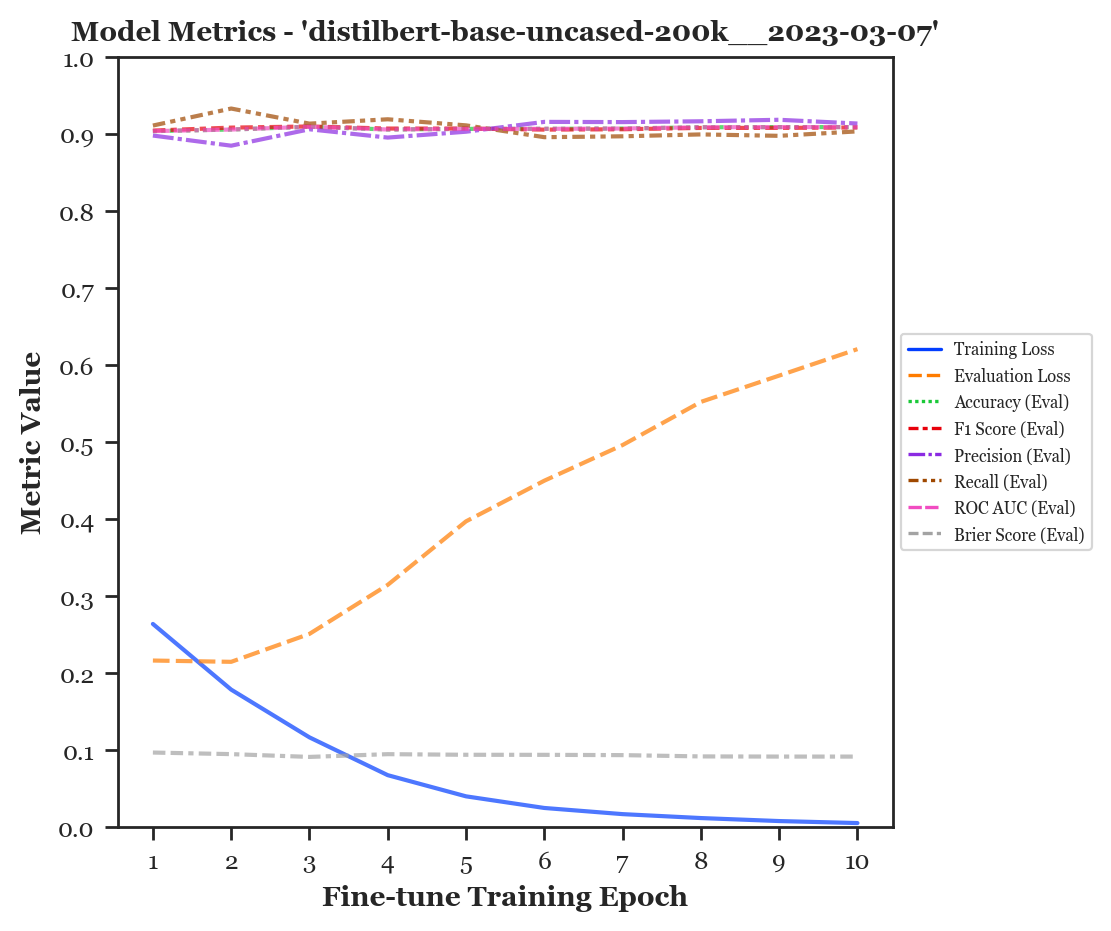

In [37]:
fig, ax = plt.subplots(figsize=(5,5))

# setup labels for axes and figure
title_text = "Model Metrics" + f" - '{run_name}'" if (run_name) else ""
ax.set_title(title_text, weight='bold', fontsize=10)
ax.set_xlabel("Fine-tune Training Epoch", weight='bold', fontsize=10)
ax.set_ylabel("Metric Value", weight='bold', fontsize=10)

LINE_WIDTH = 1.5

# plot the data
line_metadata = {
    'loss':
        {'label': "Training Loss"},
    'eval_loss':
        {'label': "Evaluation Loss"},
    'eval_accuracy': 
        {'label': "Accuracy (Eval)"},
    'eval_f1':
        {'label': 'F1 Score (Eval)'},
    'eval_precision': 
        {'label': 'Precision (Eval)'},
    'eval_recall': 
        {'label': 'Recall (Eval)'},
    'eval_roc_auc': 
        {'label': 'ROC AUC (Eval)'},
    'eval_brier_score': 
        {'label': 'Brier Score (Eval)'},
}

g = sns.lineplot(
    data=model_metrics_df[['loss', 'eval_loss', 'eval_accuracy', 'eval_f1', 
        'eval_precision', 'eval_recall', 'eval_roc_auc', 'eval_brier_score']],
    #markers=True,
    alpha=0.7,
    linewidth=LINE_WIDTH,
    linestyle='solid'
)

# setup other graph formatting
ax.set_xticks(
    np.linspace(
        start=int(np.ceil(model_metrics_df.index.min())),
        stop=int(np.ceil(model_metrics_df.index.max())),
        num=int(np.ceil(model_metrics_df.index.max())),
        dtype='int'
    ),
)

ax.set_ylim(0,1)
ax.set_yticks(
    np.linspace(
        start=0.0, stop=1.0, num=11
    )
)

handles, raw_labels = ax.get_legend_handles_labels()
pretty_labels = [line_metadata[raw_label]['label'] for raw_label in raw_labels]
ax.legend(handles, pretty_labels)
sns.move_legend(ax, "center left", bbox_to_anchor=(1,0.5), fontsize=6)

plt.savefig(f"../data/models/{output_dir_name}/model_metrics.png")

plt.show()